In [0]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import tensorflow as tf
import keras
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPool2D
from keras.optimizers import Adam, Adamax, SGD, RMSprop,Nadam
from keras.models import Model, Sequential
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.preprocessing.image import load_img,img_to_array
import pandas as p
import numpy as np
import os
import subprocess
import re
from keras.models import load_model
from scipy import ndimage, misc
from sklearn.model_selection import train_test_split
from keras import regularizers
import skimage
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import rescale,resize,downscale_local_mean
import google.colab
from google.colab.patches import cv2_imshow as imshow
from PIL import Image

Using TensorFlow backend.


In [0]:
base_model=keras.applications.vgg16.VGG16(include_top=False,input_shape=(150, 150, 3),)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01))(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='relu')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
weights=np.array(p.read_csv('/content/weights.csv'))

In [0]:
firstTime=True
if (firstTime):
  !unzip '-qq' 'people_test.zip'

%cd 'frame'
%pwd
asize=len(np.array(os.listdir('./')))
#memory costraints
asize=2449
print(len(os.listdir('./')))
img_array=np.zeros((asize,150,150,3))
lab_array=np.zeros((asize,1))
res=subprocess.Popen(['ls ./|sort -g'],shell=True, stdout=subprocess.PIPE)
stringlist=res.stdout.read().decode('utf8')
counter=0
for i in stringlist.split(sep='\n'):
  try:
    index=int(re.sub('_.*','',str(os.path.basename(i))))
    #if (index==79):  
    #  break
  except Exception as ex:
    print(ex)
    break  
  lab_array[counter,0]=weights[index,1]
  try:
    img=load_img(i,target_size=(150,150))
  except Exception as ex:
    print(ex)
  imgr=img_to_array(img)
  imgr=imgr.reshape((1,imgr.shape[0],imgr.shape[1],imgr.shape[2]))
  img_array[counter,:]=imgr[0,:]
  counter+=1
  if counter==asize:
    print("Done.")
    break
len(img_array)    

/content/frame
2927
Done.


2449

In [0]:
targ_x=np.zeros((img_array.shape[0]*3,img_array.shape[1],img_array.shape[2],img_array.shape[3]))
for i in range(0,len(img_array)-1):
  j=-1*np.ones((img_array.shape[1],img_array.shape[2],img_array.shape[3]))
  j=img_array[i,:,:,:]
  targ_x[i,:,:,:]=j
  j=ndimage.rotate(img_array[i,:,:,:],90,reshape=True)
  targ_x[i+asize,:,:,:]=j
  j=ndimage.rotate(img_array[i,:,:,:],180,reshape=True)
  targ_x[i+asize*2,:,:,:]=j
  
targ_y=np.zeros((lab_array.shape[0]*3,lab_array.shape[1]))
for i in range(0,len(lab_array)-1):
  targ_y[i,0]=lab_array[i,0]
  targ_y[i+asize,0]=lab_array[i,0]
  targ_y[i+asize*2,0]=lab_array[i,0]

img_array=targ_x
lab_array=targ_y

In [0]:
img_array, img_array_test, lab_array, lab_array_test = train_test_split( img_array, lab_array, test_size=0.10, shuffle=True)

In [0]:
from keras.optimizers import SGD,Adam,RMSprop
model.compile(optimizer=Adam(lr=0.001, decay=0.01), loss='mse', metrics=['mae','accuracy','mse'])

In [0]:
call=keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',mode='min',patience=5,restore_best_weights=True)

In [0]:
history = model.fit(img_array,lab_array,epochs=40,initial_epoch=0,batch_size=32,validation_split=0.2,shuffle=True,callbacks=[call])

Train on 5289 samples, validate on 1323 samples
Epoch 1/40
5289/5289 [==============================] - 42s 8ms/step - loss: 765.9488 - mean_absolute_error: 14.8949 - acc: 0.0285 - mean_squared_error: 716.1157 - val_loss: 155.9470 - val_mean_absolute_error: 8.8719 - val_acc: 0.0310 - val_mean_squared_error: 126.2861
Epoch 2/40
5289/5289 [==============================] - 41s 8ms/step - loss: 152.7475 - mean_absolute_error: 8.7490 - acc: 0.0372 - mean_squared_error: 126.6251 - val_loss: 143.8192 - val_mean_absolute_error: 8.6699 - val_acc: 0.0378 - val_mean_squared_error: 120.2042
Epoch 3/40
5289/5289 [==============================] - 40s 8ms/step - loss: 142.3237 - mean_absolute_error: 8.5364 - acc: 0.0410 - mean_squared_error: 120.1155 - val_loss: 127.8005 - val_mean_absolute_error: 8.1188 - val_acc: 0.0333 - val_mean_squared_error: 106.7564
Epoch 4/40
5289/5289 [==============================] - 41s 8ms/step - loss: 131.8809 - mean_absolute_error: 8.2417 - acc: 0.0391 - mean_squared

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'val_mean_squared_error', 'loss', 'mean_absolute_error', 'acc', 'mean_squared_error'])


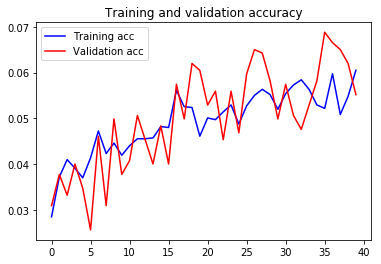

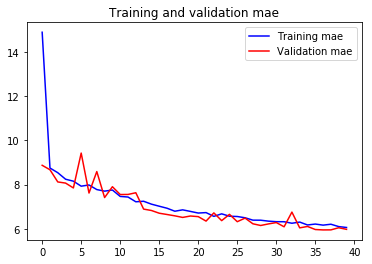

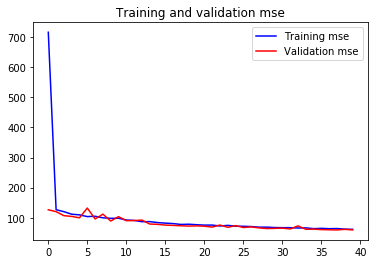

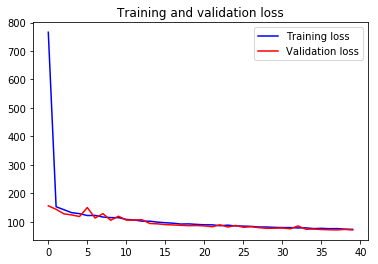

In [0]:
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, mae, 'b', label='Training mae')
plt.plot(epochs, val_mae, 'r', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
 
plt.figure()

plt.plot(epochs, mse, 'b', label='Training mse')
plt.plot(epochs, val_mse, 'r', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

['loss', 'mean_absolute_error', 'acc', 'mean_squared_error']
Testing set Mean Abs Error:  5.86 Kg Testing set accuracy: 0.05306 Testing Mean Square Error: 55.27 kg
[55.893883]


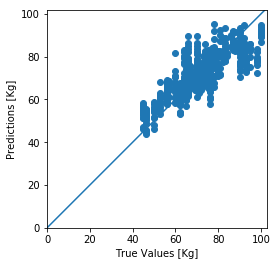

In [0]:
print(model.metrics_names)
loss, mae, acc,mse = model.evaluate(img_array_test, lab_array_test, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Kg".format(mae),"Testing set accuracy: {:5.5f}".format(acc),"Testing Mean Square Error: {:5.2f} kg".format(mse))

pred=model.predict(img_array_test[0:1])
for j in pred:
  print(j)
predictions =model.predict(img_array_test).flatten()

plt.scatter(lab_array_test, predictions)
plt.xlabel('True Values [Kg]')
plt.ylabel('Predictions [Kg]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 150], [-100, 150])
plt.savefig('/content/pred_vgg16.png')

In [0]:
model.save("/content/vgg16_trained.h5")
model.save_weights("/content/vgg16_weights_trained.h5")